# Data Processing 
This notebook will cover how we processed the data sets to be used in the model runners and other scripts.
- Receptor Binding Domain (RBD) Data Set
- Deep Mutational Scan (DMS) Data Set 
    - Expression
    - Binding
- AlphaSeq Data Set
- BetaCorona Data Set

In [1]:
import os
import re
import pandas as pd

import csv
import random
from Bio import SeqIO
from collections import defaultdict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

--- 
## RBD
From our paper, this is how this data was collected: 
> All the SARS-CoV-2 spike protein sequences were downloaded from GISAID (Elbe and Buckland‐Merrett, 2017) as of version 20230203 followed by MD5-based search for deduplication and removal of sequences with a length shorter than 600aa or containing any unknown residues (X), we obtained a dataset of 312,888 unique sequences. Using the reference sequence of RDB region (YP_009724390:319..541), we performed similarity search against the dataset using DIAMOND blastp algorithm (Buchfink et al., 2021) and extracted 312,783 RBD regions that align with the complete 223aa RBD region. All the four data sets are available for download. Sequences and metadata from GISAID can be accessed using the EPI_SET ID: EPI_SET_231127oe.

More recent data collection in May saw an increase in sequences to 347,624. There are 200 sequences that are present in the noX.RBD fasta file, but not in the GISAID metadata file. Metadata was also retrieved by parsing protein fasta header.

We applied this bash command to isolate the variant labels from the metadata file to match with the sequence IDs in the fasta file:```cat spikeprot0528.clean.uniq.noX.RBD.metadata.tsv | cut -f 5,16 | awk '{print $1, $3}' > spikeprot0528.clean.uniq.noX.RBD.metadata_variants.txt```. Let's take a closer look at the metadata and fasta file to confirm the numbers from before... We have 347432 total rows of data in the metadata.

In [2]:
data_dir = '../data'
metadata_file = os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD.metadata_variants.txt')
metadata_df = pd.read_csv(metadata_file, sep=" ", header=0)
metadata_df

,Accession,Variant
0,EPI_ISL_5120698,Delta
1,EPI_ISL_5123727,Delta
2,EPI_ISL_14904955,Omicron
3,EPI_ISL_5119677,Delta
4,EPI_ISL_14904971,Omicron
...,...,...
347427,EPI_ISL_14903692,Omicron
347428,EPI_ISL_14902388,Omicron
347429,EPI_ISL_14905423,Omicron
347430,EPI_ISL_5123715,Delta


We can compare this to the fasta file, which has 347624 total rows of data. So there are indeed 200 less lines in the metadata.

In [3]:
from Bio import SeqIO

fasta_file = os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD.fasta')

# Parse the FASTA file
fasta_data = []
for record in SeqIO.parse(fasta_file, "fasta"):
    fasta_data.append([record.id, str(record.seq)])

# Convert the list to a pandas DataFrame
fasta_df = pd.DataFrame(fasta_data, columns=['Accession', 'Sequence'])
fasta_df

,Accession,Sequence
0,EPI_ISL_10306118,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
1,EPI_ISL_15254300,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
2,EPI_ISL_1040472,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
3,EPI_ISL_3922857,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
4,EPI_ISL_2203432,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
...,...,...
347619,EPI_ISL_10943765,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...
347620,EPI_ISL_12362530,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...
347621,EPI_ISL_12083634,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...
347622,EPI_ISL_13002370,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...


Let's combine these two files using the `Accession` columns of both data frames, which refer to the sequence ID, and save the file. We will left merge metadata_df into fasta_df, so that all entries in the larger fasta_df are preserved in the merge as we match the Accession IDs in metadata_df. We'll save this file as it includes all data, especially since we used all data to train the original model runner.

In [4]:
save_as = os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD_variants_all.csv')
merged_df = pd.merge(fasta_df, metadata_df, on='Accession', how='left')
merged_df = merged_df.rename(columns={'Accession': 'seq_id', 'Sequence':'sequence', 'Variant':'variant'})
merged_df = merged_df[['seq_id', 'variant', 'sequence']]
merged_df.to_csv(save_as, index=False)
merged_df

,seq_id,variant,sequence
0,EPI_ISL_10306118,Omicron,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
1,EPI_ISL_15254300,Omicron,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
2,EPI_ISL_1040472,NaN,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
3,EPI_ISL_3922857,NaN,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
4,EPI_ISL_2203432,NaN,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
...,...,...,...
347619,EPI_ISL_10943765,Omicron,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...
347620,EPI_ISL_12362530,Omicron,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...
347621,EPI_ISL_12083634,Omicron,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...
347622,EPI_ISL_13002370,Omicron,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...


Now, let's clean this up a bit. We'll start with removing any other NaN values, and with it those 200 sequences that are not in the metadata. Now we have 306515 entries that have both sequence and variant information. We'll save this data for use in our distribution plots below, and also for use in our clustering maps.

In [5]:
save_as = os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD_variants.csv')
merged_df = merged_df.dropna(subset=['variant']).reset_index(drop=True)
merged_df.to_csv(save_as, index=False)
merged_df

,seq_id,variant,sequence
0,EPI_ISL_10306118,Omicron,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
1,EPI_ISL_15254300,Omicron,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
2,EPI_ISL_9430191,Omicron,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
3,EPI_ISL_9429868,Delta,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
4,EPI_ISL_9430172,Delta,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...
...,...,...,...
306510,EPI_ISL_10943765,Omicron,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...
306511,EPI_ISL_12362530,Omicron,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...
306512,EPI_ISL_12083634,Omicron,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...
306513,EPI_ISL_13002370,Omicron,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...


Now let's plot this to get some idea of the distribution in the data. First is the variant distribution, which is also **Figure 1A** in our paper. We can see that 3 variants stand out the most: Alpha, Delta, and Omicron. We utilize these three in the clustering notebooks, where we plot UMAP and t-SNE plots.

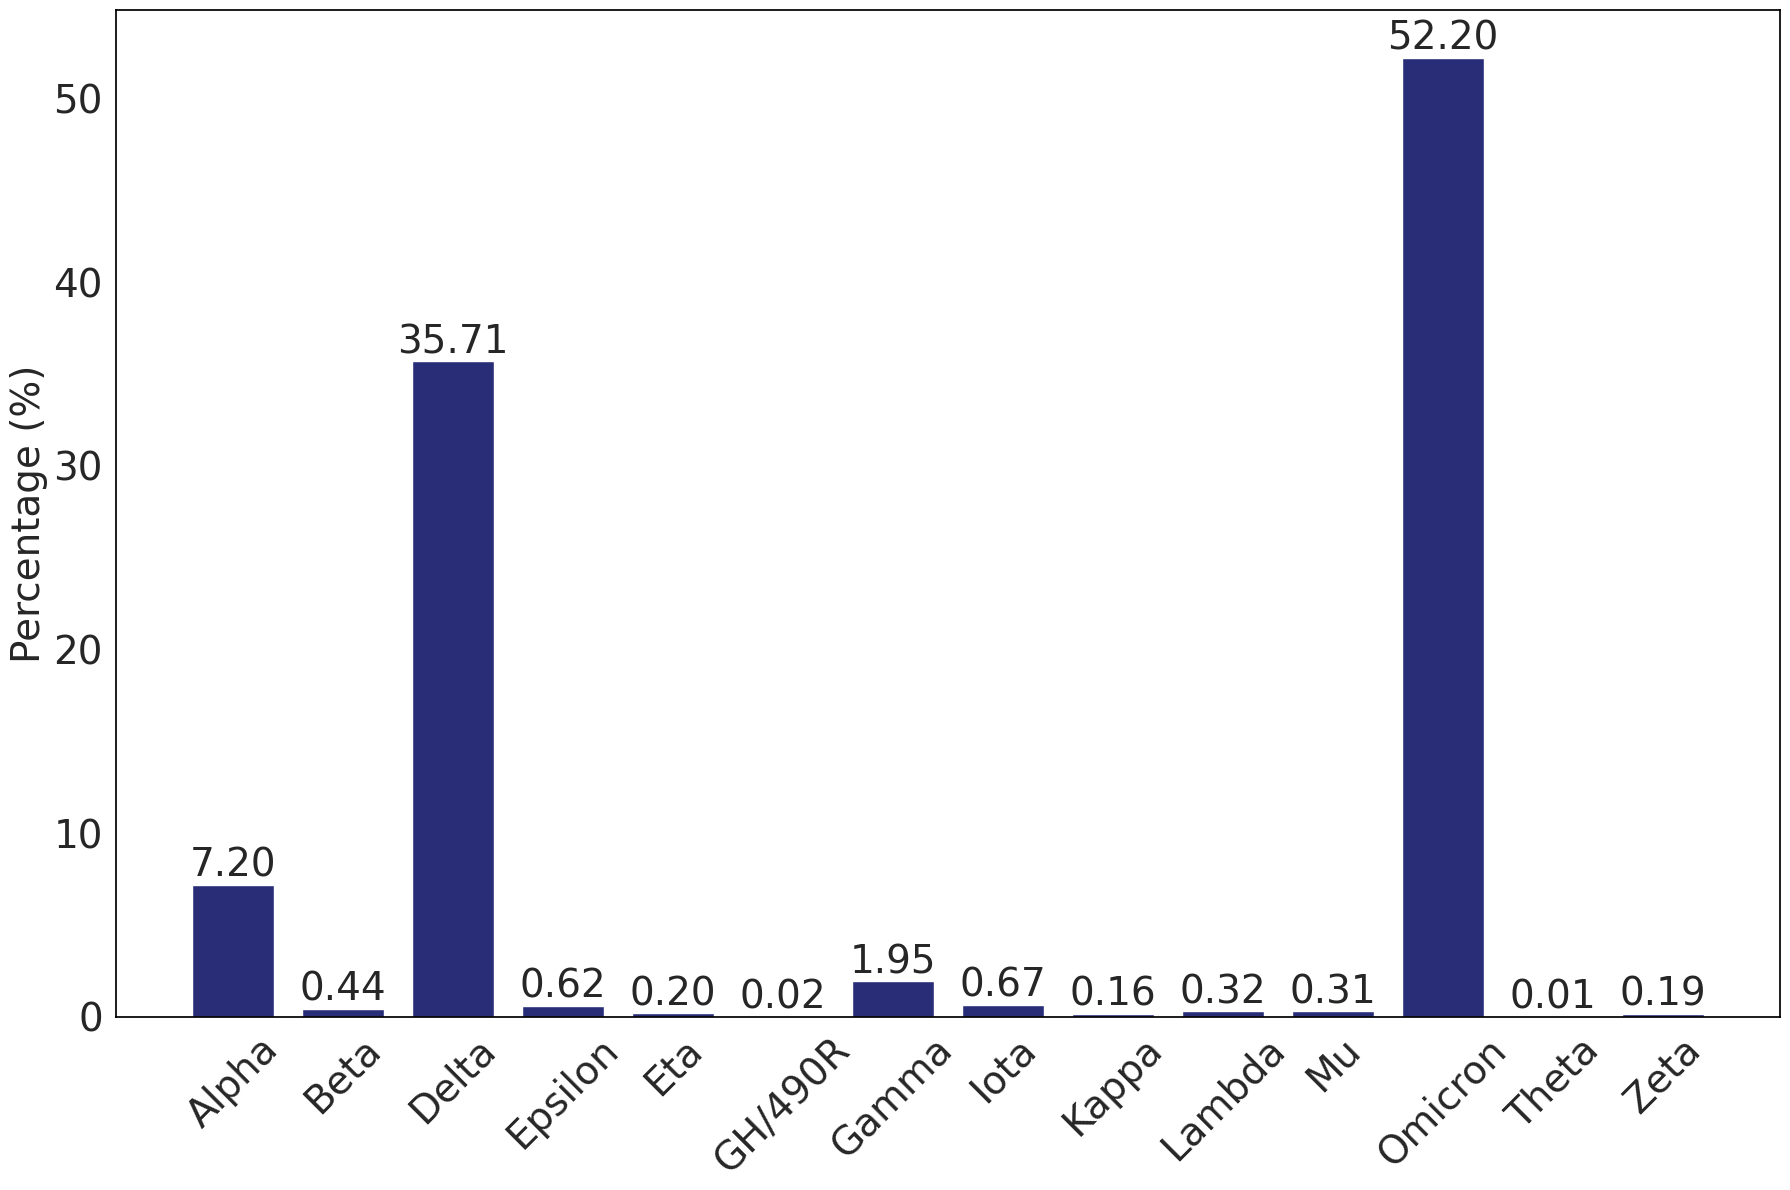

In [29]:
def plot_variant_distribution(csv_file:str):
    save_as = csv_file.replace('.csv', '_variant_percentage_distribution.pdf')
    df = pd.read_csv(csv_file, sep=',', header=0)
    all_variants = sorted(np.unique(df['variant']))
    variant_percentages = [(df['variant'] == variant).mean() * 100 for variant in all_variants]

    # Create a bar plot to visualize the distribution
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style='white')
    plt.figure(figsize=(18, 12))
    plt.rcParams['font.family'] = 'sans-serif'

    bar_width= 0.75
    x = np.arange(len(all_variants))
    bars = plt.bar(x, variant_percentages, width=bar_width, color="#292d78ff")

    # Add bar labels
    for i, percentage in enumerate(variant_percentages):
        plt.text(x[i], percentage, f'{percentage:.2f}', ha='center', va='bottom', fontsize=28)

    # Remove grey grid background
    plt.grid(False)
    plt.gca().set_facecolor('none')
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    
    #plt.title('Variant Distribution')
    fontsize = 28
    # plt.xlabel('Variant', fontsize=fontsize)
    plt.ylabel('Percentage (%)', fontsize=fontsize)
    plt.xticks(x, all_variants, fontsize=fontsize, rotation=45)
    plt.yticks(fontsize=fontsize) 
    plt.style.use('ggplot')
    plt.tight_layout()
    plt.savefig(save_as, format='pdf')
    plt.show()

merged_csv = os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD_variants.csv')
plot_variant_distribution(merged_csv)

Next, we take a look at the distribution of amino acids across all sequences, which refers to **Figure 1B**. This is useful for comparing against our original BERT model runner's heatmap in our paper. We notice that the amino acid Methionine, "M", is our lowest performing amino acid, but also the amino acid we have least of. For further breakdown of this amino acid:
- There are 3106 total Ms across all sequences
- 3093 (out of 306515), or 1.01% sequences have at least 1 M 
- Here are the breakdowns per variant that contain at least 1 M:
    - 'Iota' - has 1: 1,
    - 'Zeta' - has 1: 2,
    - 'Delta' - has 1: 86, 
    - 'Alpha' - has 1: 55, 
    - 'Eta' - has 1: 1,
    - 'Mu' - has 1: 1,
    - 'Gamma' - has 1: 6,
    - 'Omicron' - has 1: 2928, has more than 1: 13

In [ ]:
def plot_aa_distribution(csv_file:str):
    save_as = csv_file.replace('.csv', '_variant_aa_percentage_distribution.pdf')
    aa_dict = defaultdict(int)
    m_seqs = defaultdict(list)

    df = pd.read_csv(csv_file, sep=',', header=0)

    for seq_id, variant, seq in zip(df['seq_id'], df['variant'], df['sequence']):
        m_count = 0
        for aa in seq:
            aa_dict[aa] += 1
            if aa == "M":
                m_count += 1

        if "M" in seq:
            if variant not in m_seqs:
                m_seqs[variant] = [0, 0] 

            if m_count == 1:
                m_seqs[variant][0] += 1
            elif m_count > 1:
                m_seqs[variant][1] += 1

    n_m_seqs = sum([sum(counts) for counts in m_seqs.values()])
    print(f"M count: {aa_dict['M']} AAs, n seqs with M: {n_m_seqs} (out of {len(df)}), % seqs with M: {n_m_seqs/len(df)*100:.2f}%")
    print(m_seqs)

    amino_acids = sorted(aa_dict.keys())
    counts = [aa_dict[aa] for aa in amino_acids]
    total_counts = sum(counts)
    percentages = [(count/total_counts) * 100 for count in counts]

    # Create a bar plot to visualize the distribution
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style='white')
    plt.figure(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'

    x = np.arange(len(aa_dict))
    bar_width = 0.45
    plt.bar(x, percentages, width=bar_width, color="dimgrey")

    # Add bar labels
    for i, percentage in enumerate(percentages):
        plt.text(i, percentage, f'{percentage:.3f}%', ha='center', va='bottom', fontsize=10)

    # Remove grey grid background
    plt.grid(False)
    plt.gca().set_facecolor('none')
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    
    #plt.title('Amino Acid Distribution')
    plt.xlabel('Amino Acid')
    plt.ylabel('Quantity (%)')
    plt.xticks(x, amino_acids)
    plt.style.use('ggplot')
    plt.tight_layout()
    plt.savefig(save_as, format='pdf')

In [ ]:
merged_csv = os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD_variants.csv')
plot_aa_distribution(merged_csv)

---
## DMS
We utilize the DMS [expression](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS/blob/master/results/expression_meanFs/expression_meanFs.csv) and [binding](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS/blob/master/results/binding_Kds/binding_Kds.csv) data sets from the 'Deep Mutational Scanning of SARS-CoV-2 Receptor Binding Domain Reveals Constraints on Folding and ACE2 Binding' paper by Starr et al. We need to do some data processing prior to usage within our ML models. This portion of the notebook will cover the `process_dms.py` script.

We will need to utilize the below function for these DMS data sets. Given the below reference sequence, this applies the mutations present in the mutation label, or `aa_substitions` column in both .csv, to the reference sequence. This gives us our protein sequence that we later use in our models.

In [ ]:
def label_to_seq(label: str) -> str:
    """ Generate sequence based on reference sequence and mutation label. """

    refseq = list('NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST')
    seq = refseq.copy()
    p = '([0-9]+)'
    if '_' in label:
        for mutcode in label.split('_'):
            [ori, pos, mut] = re.split(p, mutcode)
            pos = int(pos)-1    # use 0-based counting
            assert refseq[pos].upper() == ori
            seq[pos] = mut.upper()
        seq = ''.join(seq)
        return seq

    if label=='wildtype': return ''.join(seq)

    [ori, pos, mut] = re.split(p, label)
    pos = int(pos)-1    # use 0-based counting
    assert refseq[pos] == ori
    seq[pos] = mut.upper()
    seq = ''.join(seq)
    return seq

### Expression
Let's load in our first data set, `dms_expression_meanFs.csv` (renamed for organizational purposes, originally downloaded as `expression_meanFs.csv`). The following sections will be an expanded version of the function `process_data`. We will be focusing on 3 main columns to process our data: 
- `ML_meanF`, 
- `variant_class`, and 
- `aa_substitutions`.

In [ ]:
data_dir = '../data'

# Load in .csv
expression_csv = os.path.join(data_dir, 'dms_expression_meanFs.csv')
expression_df = pd.read_csv(expression_csv, sep=',', header=0)
expression_df

Nice, we have 195081 rows of data to start with. Now we want to drop the entries that have any NA/N values. This leaves us with 179005 remaining entries.

In [ ]:
# Remove rows where specified column is NA
expression_df = expression_df.dropna(subset=['ML_meanF']).reset_index(drop=True)
print(len(expression_df))

Let's take a look at how many of each `variant_class` there are. In the end, we want to filter out any variant classes that are not nonsynonymous mutations. We should have 147739 nonsynonymous mutations total.

In [ ]:
# Count number of entries per variant class
value_counts = expression_df['variant_class'].value_counts()
print(value_counts)

# Filter out variant classes that are not nonsynonymous
nonsynonymous_df = expression_df[expression_df['variant_class'].str.contains('nonsynonymous', case=False, na=False)]
print(len(nonsynonymous_df))

Now we want to acquire the unique nonsynonymous mutations. We will do this by creating a new DataFrame taking the mean value of `ML_meanF` across each `aa_substitutions`. We then merge this new DataFrame with the older DataFrame containing only nonsynonymous mutations, replacing the old `ML_meanF` column with the new one with mean values for duplicate `aa_substitutions` nonsynonymous mutations. Then we drop any of these duplicates, leaving 116257 unique nonsynonymous mutations. 

We can also double check that we have no duplicates by counting the number of unique values in `aa_substitutions`. It matches with 116257 entries!

In [ ]:
# Group by 'aa_substitutions' and calculate the mean of the specified value column for each group
unique_nonsynonymous_df = nonsynonymous_df.groupby('aa_substitutions', as_index=False)['ML_meanF'].mean()

# Merge dfs, replace duplicate with average
merged_df = pd.merge(unique_nonsynonymous_df, nonsynonymous_df.drop(columns='ML_meanF'), on='aa_substitutions', how='left')

# Drop duplicate rows based on 'aa_substitutions'
merged_df = merged_df.drop_duplicates(subset='aa_substitutions').reset_index(drop=True)
print(len(merged_df))

# Count number of unique nonsynonymous mutations
unique_nonsynonymous_mutations_counts = merged_df['aa_substitutions'].nunique()
print(f"Number of unique nonsynonymous mutations: {unique_nonsynonymous_mutations_counts}")

Now we can select down to the columns we want, `aa_substitution` and `ML_meanF`. To match with the formatting of the `label_to_seq` function, we need to replace all spaces ' ' in `aa_substitutions` with underscores '_'. After, we can create a new column in our DataFrame containing the sequence (reference sequence with substitutions applied), and also rename the `aa_substitutions` to `labels`.

In [ ]:
# Filter to only the columns we want and copy the DataFrame to avoid SettingWithCopyWarning
unique_filtered_df = merged_df[['aa_substitutions', 'ML_meanF']].copy()

# Add '_' to substitutions
unique_filtered_df.loc[:, 'aa_substitutions'] = unique_filtered_df['aa_substitutions'].replace(' ', '_', regex=True)

# Utilize 'aa_substitutions' to generate the mutated sequence
unique_filtered_df['sequence'] = unique_filtered_df['aa_substitutions'].apply(label_to_seq)

# Change 'aa_substitutions' to 'labels'
unique_filtered_df = unique_filtered_df.rename(columns={'aa_substitutions': 'labels'})
unique_filtered_df

We save our data as a whole data set. Then, finally, we split our data into an 80/20 distribution between training and testing. We utilize the `split_csv` function from `split_data.py`, which splits the data 80/20 randomly based on the random seed (we use 0 as the random seed). 

In [ ]:
def split_csv(rnd_seed: int, input_csv: str):
    """
    Split csv file into train, test data.
    """
    train_csv = input_csv.replace('.csv', '_train.csv')
    test_csv  = input_csv.replace('.csv', '_test.csv')

    with open(input_csv, "r") as input_file:
        reader = csv.reader(input_file)
        header = next(reader)
        input_records = list(reader)

    random.seed(rnd_seed)
    random.shuffle(input_records)

    split_idx = int(0.8 * len(input_records))
    train_records = input_records[:split_idx]
    test_records = input_records[split_idx:]

    with open(train_csv, 'w') as ft, open(test_csv, 'w') as fv:
        train_writer = csv.writer(ft)
        test_writer = csv.writer(fv)

        train_writer.writerow(header)
        test_writer.writerow(header)

        for record in train_records:
            train_writer.writerow(record)

        for record in test_records:
            test_writer.writerow(record)

    print(f'Total: {len(input_records)}, Train: {len(train_records)}, Test: {len(test_records)}')

In [ ]:
# Save processed data to .csv
save_as = os.path.join(data_dir, 'dms_mutation_expression_meanFs.csv')
unique_filtered_df.to_csv(save_as, index=False)

# Split to train, test data (80/20)
rnd_seed = 0
split_csv(rnd_seed, save_as)

Our final numbers for the processed data: 
- Total: 116257
    - Train: 93005
    - Test: 23252

We also have a separate file that includes all nonsynonmyous mutations. This is for observing the distributions found in `plot_dms_distribution.py`.

In [ ]:
duplicate_filtered_df = nonsynonymous_df.copy()
duplicate_filtered_df.loc[:, 'aa_substitutions'] = duplicate_filtered_df['aa_substitutions'].replace(' ', '_', regex=True)
duplicate_filtered_df['sequence'] = duplicate_filtered_df['aa_substitutions'].apply(label_to_seq)
duplicate_filtered_df = duplicate_filtered_df.rename(columns={'aa_substitutions': 'labels'})

save_as = os.path.join(data_dir, 'dms_mutation_expression_meanFs.csv')
unique_filtered_df.to_csv(save_as, index=False)

### Binding
We can run the same process on the binding DMS data set.

Our final numbers for the processed data: 
- Total: 105525
    - Train: 84420
    - Test: 21105

In [ ]:
def process_data(input_csv, output_csv):
    """ 
    Process the DMS binding and expression datasets.
    - Drop NAs
    - Select only nonsynonymous variant classes
    - Select unique nonsynonymous mutations
        - For duplicate aa_substitutions, take the mean value of log10Ka or ML_meanF
    - Apply mutations to reference sequence
    """

    if  "binding" in input_csv:
        value_column = "log10Ka"
        print("Looking at DMS binding dataset.")
    elif "expression" in input_csv:
        value_column = "ML_meanF"
        print("Looking at DMS expression dataset.")

    full_df = pd.read_csv(input_csv, sep=',', header=0)
    row_count = len(full_df)
    print(f"Number of data points: {row_count}")

    # Remove rows where specified column is NA
    full_df = full_df.dropna(subset=[value_column]).reset_index(drop=True)
    print(f"Number of data points with na: {row_count-len(full_df)}")
    print(f"Number of data points left {len(full_df)}")
    
    # Count number of entries per variant class
    value_counts = full_df["variant_class"].value_counts()
    print(f"{value_counts}")
    # Filter out variant classes that are not nonsynonymous
    nonsynonymous_df = full_df[full_df['variant_class'].str.contains('nonsynonymous', case=False, na=False)]
    
    # Group by 'aa_substitutions' and calculate the mean of the specified value column for each group
    unique_nonsynonymous_df = nonsynonymous_df.groupby('aa_substitutions', as_index=False)[value_column].mean()
    # Merge dfs
    merged_df = pd.merge(unique_nonsynonymous_df, nonsynonymous_df.drop(columns=value_column), on='aa_substitutions', how='left')
    # Drop duplicate rows based on 'aa_substitutions'
    merged_df = merged_df.drop_duplicates(subset='aa_substitutions').reset_index(drop=True)
    # Count number of unique nonsynonymous mutations
    unique_nonsynonymous_mutations_counts = merged_df['aa_substitutions'].nunique()
    print(f"Number of unique nonsynonymous mutations: {unique_nonsynonymous_mutations_counts}")
    
    # Filter to only the columns we want and copy the DataFrame to avoid SettingWithCopyWarning
    unique_filtered_df = merged_df[["aa_substitutions", value_column]].copy()
    duplicate_filtered_df = nonsynonymous_df.copy()
    # Add '_' to substitutions
    unique_filtered_df.loc[:, "aa_substitutions"] = unique_filtered_df["aa_substitutions"].replace(' ', '_', regex=True)
    duplicate_filtered_df.loc[:, "aa_substitutions"] = duplicate_filtered_df["aa_substitutions"].replace(' ', '_', regex=True)
    # Utilize "aa_substitutions" to generate the mutated sequence
    unique_filtered_df['sequence'] = unique_filtered_df['aa_substitutions'].apply(label_to_seq)
    duplicate_filtered_df['sequence'] = duplicate_filtered_df['aa_substitutions'].apply(label_to_seq)
    # Change "aa_substitutions" to "labels"
    unique_filtered_df = unique_filtered_df.rename(columns={"aa_substitutions": "labels"})
    duplicate_filtered_df = duplicate_filtered_df.rename(columns={"aa_substitutions": "labels"})
    
    # Save to csv
    unique_filtered_df.to_csv(output_csv, index=False)
    duplicate_output_csv = output_csv.replace("mutation", "duplicate_mutation")
    duplicate_filtered_df.to_csv(duplicate_output_csv, index=False)

    # Split to train, test data (80/20)
    rnd_seed = 0
    split_csv(rnd_seed, output_csv)
    print("")

In [ ]:
binding_csv = os.path.join(data_dir, 'dms_binding_Kds.csv')
save_as = os.path.join(data_dir, 'dms_mutation_binding_Kds.csv')
process_data(binding_csv, save_as)

### Distribution of Data
Let's take a look at some distributions of the data these are similar and generated in the same way to the **Supplementary Figure 5A and 5B**, but are not currently in the manuscript supplementary section. First up, the function `plot_value_distribution` creates a plot that consists of the distribution of the measured binding or expression value. We plot this using the unique nonsynonymous mutation dataset. We will load from the .csv, just to make sure it was created properly.

In [ ]:
def plot_value_distribution(df, value_col:str, save_as:str=None):
    """ 
    Plots the measured value (binding log10Ka or expression ML_meanF) distribution. 
    """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style='white')
    plt.figure(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'

    # Create histogram and kde plot
    sns.histplot(df[value_col], kde=False, stat='density', bins=100, color='dimgrey', edgecolor='black')
    sns.kdeplot(df[value_col], color='red', linewidth=2)

    plt.tight_layout()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(f'Measured {value_col}', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.show()

In [ ]:
# Expression Data Set
expression_csv = os.path.join(data_dir, 'dms_duplicate_mutation_expression_meanFs.csv')
unique_expression_df = pd.read_csv(expression_csv, sep=',', header=0)
plot_value_distribution(unique_expression_df, 'ML_meanF')

In [ ]:
# Binding Data Set
binding_csv = os.path.join(data_dir, 'dms_duplicate_mutation_binding_Kds.csv')
unique_binding_df = pd.read_csv(binding_csv, sep=',', header=0)
plot_value_distribution(unique_binding_df, 'log10Ka')

We can also look at the distribution of (Root Mean Squared Error) RMSE values. We can then use these to compare to our model runs and their RMSE plots.

In [ ]:
def plot_rmse_distribution(df, save_as:str=None):
    """ 
    Plots the RMSE density distribution for repeated sequences. 
    """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style='white')
    plt.figure(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'

    # Create histogram and kde plot
    sns.histplot(df['rmse'], kde=False, stat='density', bins=100, color='dimgrey', edgecolor='black')
    sns.kdeplot(df['rmse'], color='red', linewidth=2)

    plt.tight_layout()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('RMSE', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.show()

In [ ]:
# Expression Data Set

# Mean ML_meanF and RMSE calculation
expression_df = pd.read_csv(expression_csv, sep=',', header=0)
expression_df = expression_df[['labels', 'ML_meanF', 'sequence']].copy()
expression_df['mean_ML_meanF'] = expression_df.groupby('labels')['ML_meanF'].transform('mean')
expression_df['squared_difference'] = (expression_df['ML_meanF'] - expression_df['mean_ML_meanF'])**2
expression_df['mse'] = expression_df.groupby('labels')['squared_difference'].transform('mean')
expression_df['rmse'] = np.sqrt(expression_df['mse'])
unique_expression_df = expression_df.drop_duplicates(subset='labels', keep='first')
plot_rmse_distribution(unique_expression_df)

In [ ]:
# Binding Data Set

# Mean log10KA and RMSE calculation 
binding_df = pd.read_csv(binding_csv, sep=',', header=0)
binding_df = binding_df[['labels', 'log10Ka', 'sequence']].copy()
binding_df['mean_log10Ka'] = binding_df.groupby('labels')['log10Ka'].transform('mean')
binding_df['squared_difference'] = (binding_df['log10Ka'] - binding_df['mean_log10Ka'])**2
binding_df['mse'] = binding_df.groupby('labels')['squared_difference'].transform('mean')
binding_df['rmse'] = np.sqrt(binding_df['mse'])
unique_binding_df = binding_df.drop_duplicates(subset='labels', keep='first')
plot_rmse_distribution(unique_binding_df)

---
## AlphaSeq Data Set

For the AlphaSeq data set, we used an already cleaned dataset from a past project that Kaetlyn Gibson worked on, [Machine Learning Approach to a Novel Curated Covid-19 Antibody Database](https://github.com/rferina/covid_machine_learning/tree/main?tab=readme-ov-file#machine-learning-approach-to-a-novel-curated-covid-19-antibody-database). The script below was provided by the [github](https://github.com/rferina/covid_machine_learning/blob/main/data_cleaning_scripts/AlphaSeq/clean_AlphaSeq.py#L5).

The AlphaSeq data set was collected by Emily Engelhart, Ryan Emerson, Leslie Shing, Chelsea Lennartz, Daniel Guion, Mary Kelley, Charles Lin, Randolph Lopez, David Younger & Matthew E. Walsh, [A dataset comprised of binding interactions for 104,972 antibodies against a SARS-CoV-2 peptide](https://www.nature.com/articles/s41597-022-01779-4).

The raw data contained 14 [columns](https://www.nature.com/articles/s41597-022-01779-4/tables/5):
* POI - Alphanumeric label corresponding to amino acid sequence
* Sequence - Single letter amino acid representation of scFv measured.
* Target - Protein target represented by a text label for which the measured antibody interacted with.
* Assay - Unique assay identifier, either 1 or 2
* Replicate - Unique replicate identifier, either 1, 2 or 3
* Pred_affinity - Value representing the score from the AlphaSeq assay. These values estimate the protein-protein dissociation constant in nanomolar, on a log scale, and are the result of empirical measurement. Lower values indicate stronger binding.
* HC - Single letter amino acid sequence of the heavy chain (HC).
* LC - Single letter amino acid sequence of the light chain (LC)
* CDRH1 - Single letter amino acid sequence of a CDR region where H indicates heavy chain and the numerical value represents CDR 1.
* CDRH2 - Single letter amino acid sequence of a CDR region where H indicates heavy chain and the numerical value represents CDR 2.
* CDRH3 - Single letter amino acid sequence of a CDR region where H indicates heavy chain and the numerical value represents CDR 3.
* CDRL1 - Single letter amino acid sequence of a CDR region where L indicates light chain and the numerical value represents CDR 1.
* CDRL2 - Single letter amino acid sequence of a CDR region where L indicates light chain and the numerical value represents CDR 2.
* CDRL3 - Single letter amino acid sequence of a CDR region where L indicates light chain and the numerical value represents CDR 3.

### Load in Raw Data and Count all Unique Values from the Columns

In [ ]:
data_dir = '../data'
alpha_seq_data = pd.read_csv(os.path.join(data_dir, "MITLL_AAlphaBio_Ab_Binding_dataset.csv"))

print(alpha_seq_data.head())

# look at unique values in all columns
poi_unique = alpha_seq_data['POI'].unique()
seq_unique = alpha_seq_data['Sequence'].unique()
target_unique = alpha_seq_data['Target'].unique()
assay_unique = alpha_seq_data['Assay'].unique() #1,2
replicate_unique = alpha_seq_data['Replicate'].unique() #1,2,3
affinity_unique = alpha_seq_data['Pred_affinity'].unique()
hc_unique = alpha_seq_data['HC'].unique()
lc_unique = alpha_seq_data['LC'].unique()
cdrh1_unique = alpha_seq_data['CDRH1'].unique()
cdrh2_unique = alpha_seq_data['CDRH2'].unique()
cdrh3_unique = alpha_seq_data['CDRH3'].unique()
cdrl1_unique = alpha_seq_data['CDRL1'].unique()
cdrl2_unique = alpha_seq_data['CDRL2'].unique()
cdrl3_unique = alpha_seq_data['CDRL3'].unique()

print('hc', len(hc_unique)) # 48928
print('lc', len(lc_unique)) # 56043
print('cdrh1', len(cdrh1_unique)) # 7868
print('cdrh2', len(cdrh2_unique)) # 18150
print('cdrh3', len(cdrh3_unique)) # 6799
print('cdrl1', len(cdrl1_unique)) # 19656 
print('cdrl2', len(cdrl2_unique)) # 5526
print('cdrl3', len(cdrl3_unique)) # 11325

### Find Length of Sequences and Check for Empty Entries

In [ ]:
# check unique lengths of entries to see how long sequences are; if there are missing entries
def len_checker(data, col):
    """
    Takes in dataframe column, returns unique lengths of
    entries in a set.
    """
    len_set = set()
    for item in data[col]:
        length = len(item)
        len_set.add(length)
    return len_set

# poi len set: {8, 9, 10, 11, 12, 14}
print('poi:', len_checker(alpha_seq_data, 'POI'))
# seq len set: {240, 249, 246}
print('sequence:', len_checker(alpha_seq_data, 'Sequence'))
# target len set: {9, 10}
print('target:', len_checker(alpha_seq_data, 'Target'))
# doesn't work for assay, replicate, or pred_affinity because they're integers not in a list
# HC len set: {117, 118, 119}
print('hc:', len_checker(alpha_seq_data, 'HC'))
# LC len set: {113, 115, 108}
print('lc:', len_checker(alpha_seq_data, 'LC'))
# cdrh1 len set: {10}
print('cdrh1:', len_checker(alpha_seq_data, 'CDRH1'))
# cdrh2: {16}
print('cdrh2:', len_checker(alpha_seq_data, 'CDRH2'))
# cdrh3: {8, 9, 10}
print('cdrh3:', len_checker(alpha_seq_data, 'CDRH3'))
# cdrl1: {17, 11, 14}
print('cdrl1:', len_checker(alpha_seq_data, 'CDRL1'))
# cdrl2: {13, 7}
print('cdrl2:', len_checker(alpha_seq_data, 'CDRL2'))
# cdrl3: {9, 11}
print('cdrl3:', len_checker(alpha_seq_data, 'CDRL3'))

### Check for Missing Values from Columns and Remove them
Missing values were only found in `Pred_affinity`

In [ ]:
# check for missing values in all columns; found only in Pred_affinity
print(alpha_seq_data['POI'].isna().sum()) # 0
print(alpha_seq_data['Sequence'].isna().sum()) # 0
print(alpha_seq_data['Target'].isna().sum()) # 0
print(alpha_seq_data['Assay'].isna().sum()) # 0
print(alpha_seq_data['Replicate'].isna().sum()) # 0
print('pred affinity:', alpha_seq_data['Pred_affinity'].isna().sum()) # 907561
print(alpha_seq_data['HC'].isna().sum()) # 0
print(alpha_seq_data['LC'].isna().sum()) # 0
print(alpha_seq_data['CDRH1'].isna().sum()) # 0
print(alpha_seq_data['CDRH2'].isna().sum()) # 0
print(alpha_seq_data['CDRH3'].isna().sum()) # 0
print(alpha_seq_data['CDRL1'].isna().sum()) # 0
print(alpha_seq_data['CDRL2'].isna().sum()) # 0
print(alpha_seq_data['CDRL3'].isna().sum()) # 0

# confirmed that total missing entries for dataframe are only in Pred_affinity column
print('total na values:', alpha_seq_data.isnull().sum().sum())  # 907561
# 1259701 - 907561 = 352140 usable entries (352139 not counting header line)

na_free = alpha_seq_data.dropna()
print('no seq NA len:', len(na_free))  # 352139 as expected

### Put `Sequence` duplicates in a Set

In [ ]:
# check for duplicate sequences by putting sequences in set
sequence_set = set()
for seq in na_free['Sequence']:
    sequence_set.add(seq)
print('seq set:', len(sequence_set)) # 87807 unique sequences

### Create a new column for Mean Affinity
Mean affinity is calculated by taking the average of the `Pred_affinity` from each `POI`

In [ ]:
# create new column with average affinity for each replicate
na_free['Mean_Affinity'] = na_free['Pred_affinity'].groupby(na_free['POI']).transform('mean')

### Drop all duplicate sequences

In [ ]:
# drop replicates using sequences
dedup_alpha_seq = na_free.drop_duplicates(subset='Sequence', keep='first')
print('dedup len:', len(dedup_alpha_seq)) # 87807

### Create a new CSV with Clean Data
The clean data has removed all entries that are empty. It has created a new column for `Mean_Affinity` and dropped all duplicate sequences.

In [ ]:
# write out NA-free averaged replicate data to clean csv
dedup_alpha_seq.to_csv(os.path.join(data_dir, "clean_avg_alpha_seq.csv"), index=False) 

---
## Beta-Corona Virus Data Set (Refers to Table 1)

Most of the [data](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS/blob/master/data/alignments/unaligned-sequences/RBDs.fasta) for the Beta-Corona Virus data set was gathered from a paper, [Deep mutational scanning of SARS-CoV-2 receptor binding domain reveals constraints on folding and ACE2 binding](https://www.sciencedirect.com/science/article/pii/S0092867420310035?via%3Dihub), conducted by Tyler Starr, Allie Greaney, and Jesse Bloom. 

The MERS sequences were manually extracted from querying the accession number [ALA49374.1](https://www.ncbi.nlm.nih.gov/protein/ALA49374.1) through [blastp](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PAGE=Proteins&PROGRAM=blastp&PAGE_TYPE=BlastSearch&BLAST_SPEC=). After obtaining the FASTA file, we changed the FASTA file to a CSV. 

In [ ]:
"""
Change FASTA file to csv
"""

fasta_file = 'MERS_seq.fasta'
csv_file = 'MERS_seq.csv'

with open(csv_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['ID', 'Sequence'])  # Write header

    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        csvwriter.writerow([seq_record.id, str(seq_record.seq)])

After obtaining the CSV, we went through the sequences to find their RBD [region](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd21486). Then, we parsed through all the RBD sequences and removed the ones that were the same. We finally combined the two data sets together to form `betacoronavirus_seq.csv` and `betacoronavirus_seq.fasta`